# Logisitic regression for the Open University Learning Analytics Dataset (OULAD)

This is done for Research Question 1. The target is to find what are the most important features when predicting student achievement. The features are built using information from the entire duration of the course.

Here, we are using the Logistic Regression algorithm and the goal is to have the highest possible accuracy. For this, we use methods such as hyperparameter tuning and analyse if recursive feature elimination helps us to achieve our goal. Nonetheless, we use 4 methods to find the most important features.

In [1]:
import pandas as pd # import the used libraries
import matplotlib.pyplot as plt
import shap # use pip install shap command to install the library
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


Read the data created by Q1_Final_dataset_dev.ipynb.

In [2]:
data_encoded = pd.read_csv('../Q1TransitionFolder/Q1_data_encoded.csv')
print(data_encoded.shape)
data_encoded.head(5)

(20285, 17)


,gender,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,sum_click,consistency,TMA_average,CMA_average,TMA_score,CMA_score,Total_average_score,Total_assessment_score,submission_date_average
0,1,3,9.0,2.0,0,240,0,1,934.0,13.701990,82.0,0.0,8240.0,0.0,82.0,8240.0,-1.8
1,0,3,2.0,1.0,0,60,0,1,1435.0,14.307774,66.4,0.0,6540.0,0.0,66.4,6540.0,0.0
2,0,2,5.0,1.0,0,60,0,1,2158.0,13.366931,76.0,0.0,7630.0,0.0,76.0,7630.0,-2.0
3,0,1,5.0,0.0,0,60,0,1,1034.0,10.812709,54.4,0.0,5500.0,0.0,54.4,5500.0,11.4
4,1,2,8.0,1.0,0,60,0,1,2445.0,21.084048,68.0,0.0,6690.0,0.0,68.0,6690.0,2.0


In [3]:
# Separate the target variable, which is 'final_result' from the rest of the independent variables.
X = data_encoded.drop(columns=['final_result'])
y = data_encoded['final_result']

columns = X.columns.tolist()

# we choose a random state to have deterministic results
RANDOM_STATE = 42

This is the hyperparameter tuning part for Logistic Regression.

In [41]:
# Define a pipeline to standardise the data and train the model
pipeline = Pipeline([
    ('std', StandardScaler()),
    ('classifier', LogisticRegression(random_state=RANDOM_STATE))
])

# Define the parameter grid for grid search.
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga'],
    'classifier__max_iter': [10, 50, 100, 300, 500, 1000, 5000],
}

# We define cross-validation, using stratified k-fold, to ensure proportions.
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

# Initialise the grid search, targeting to increase the accuracy metric.
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='accuracy', cv=cv, n_jobs=-1, verbose=2)

# Testing the combinations of hyperparameters
grid_search.fit(X, y)

# Print the best parameters determined by the grid search
print(grid_search.best_params_)

# Current best set:
# {'classifier__C': 100, 'classifier__max_iter': 10, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}

Fitting 3 folds for each of 168 candidates, totalling 504 fits
{'classifier__C': 100, 'classifier__max_iter': 10, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}


In [4]:
# Scale the data using the standard scaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and test sets, where 80% is used for training and 20% for testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y)

In [5]:
# Initialize our classifier using the hyperparameters obtained earlier
clf = LogisticRegression(C= 100, max_iter= 10, penalty= 'l2', solver='liblinear',random_state=RANDOM_STATE)

# Fit the model on the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

# Calculate ROC AUC
roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
print(f"ROC AUC: {roc_auc}")

# Print detailed classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.8439733793443431
F1 Score: 0.8949377593360995
ROC AUC: 0.8940323005593394
              precision    recall  f1-score   support

           0       0.76      0.65      0.70      1127
           1       0.87      0.92      0.89      2930

    accuracy                           0.84      4057
   macro avg       0.81      0.78      0.80      4057
weighted avg       0.84      0.84      0.84      4057



# Feature importance analysis

In this section, we will analyse the importance of the features. For this, we will use recursive feature elimination, the coefficients of the model, the permutation importance method and SHapley Additive exPlanations (SHAP)

In [16]:
best_accuracy = 0
best_num_features = 0
best_feature_set = None  # To store the best set of features
all_accuracies = []  # List to store all accuracy scores

for i in range(1, 17):
    # Initialize the Recursive Feature Elimination (RFE)
    rfe = RFE(estimator=LogisticRegression(C= 100, max_iter= 10, penalty= 'l2', solver='liblinear', random_state=RANDOM_STATE), n_features_to_select=i)

    # Fit RFE on the training data
    rfe.fit(X_train, y_train)

    # Predict the class labels for the test set
    y_pred_rfe = rfe.predict(X_test)

    # Calculate the accuracy score for the predictions
    accuracy = accuracy_score(y_test, y_pred_rfe)
    all_accuracies.append(accuracy)

    # If the current accuracy is better than our best, update our best metrics
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_num_features = i
        best_feature_set = [col for col, selected in zip(columns, rfe.support_) if selected]

# Results
print(f"Best number of features: {best_num_features} with Accuracy: {best_accuracy}")
print(f"Best feature set: {best_feature_set}")

Best number of features: 9 with Accuracy: 0.8442198668967217
Best feature set: ['gender', 'studied_credits', 'sum_click', 'consistency', 'TMA_average', 'CMA_average', 'TMA_score', 'Total_average_score', 'Total_assessment_score']


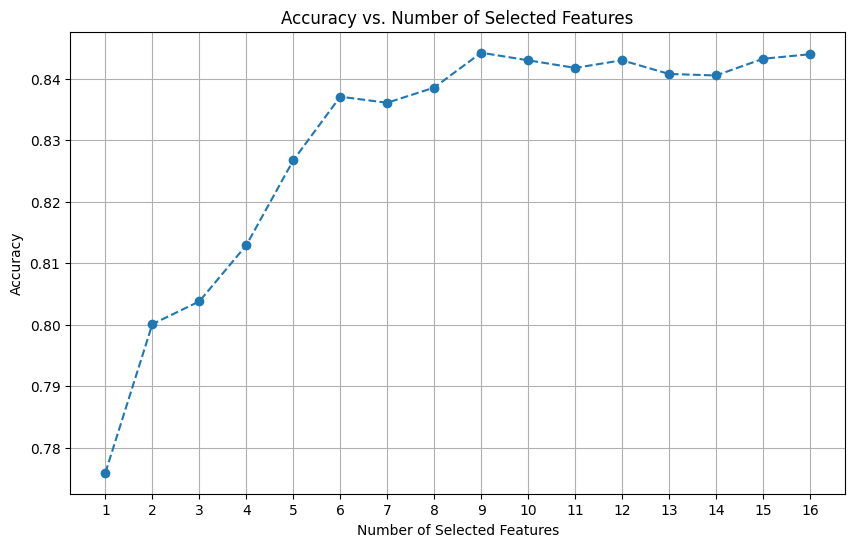

In [15]:
# Visualization of the accuracy values for RFE
plt.figure(figsize=(10, 6))
plt.plot(range(1, 17), all_accuracies, marker='o', linestyle='--')
plt.title('Accuracy vs. Number of Selected Features')
plt.xlabel('Number of Selected Features')
plt.ylabel('Accuracy')
plt.xticks(np.arange(1, 17, 1))
plt.grid(True)
plt.show()

In [6]:
# Retrieve the coefficients from the trained model.
coefs = clf.coef_[0]

# Compute the absolute values of coefficients and sort them
top_indices = np.abs(coefs).argsort()[::-1][:16]

top_features = np.array(columns)[top_indices]
top_coefs = coefs[top_indices]

# Zip the values with the names of the columns
for feature, coef in zip(top_features, top_coefs):
    print(f"Feature: {feature}, Coefficient: {coef}")

Feature: sum_click, Coefficient: 0.9882744972671734
Feature: Total_average_score, Coefficient: 0.8790816850173144
Feature: Total_assessment_score, Coefficient: 0.7069281469171422
Feature: TMA_score, Coefficient: 0.70114161726536
Feature: consistency, Coefficient: -0.4910481702082045
Feature: TMA_average, Coefficient: -0.33109078126441466
Feature: studied_credits, Coefficient: -0.3301066858683738
Feature: gender, Coefficient: -0.30439814291527884
Feature: CMA_average, Coefficient: 0.2557238766724138
Feature: num_of_prev_attempts, Coefficient: -0.20691171473479633
Feature: submission_date_average, Coefficient: -0.13352370311590359
Feature: imd_band, Coefficient: 0.0881056883692461
Feature: highest_education, Coefficient: 0.08509864498653083
Feature: CMA_score, Coefficient: 0.06288261878549918
Feature: age_band, Coefficient: 0.04509345558433302
Feature: disability, Coefficient: 0.014562667863721733


In [10]:
# Compute feature importances
result = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=RANDOM_STATE, scoring="accuracy")

top_indices = result.importances_mean.argsort()[::-1][:16]

# Get the feature names corresponding to the top importances
top_features = [columns[i] for i in top_indices]
top_importances = result.importances_mean[top_indices]

# Zip the values with the names of the columns
for feature, importance in zip(top_features, top_importances):
    print(f"Feature: {feature}, Importance: {importance}")

Feature: Total_average_score, Importance: 0.051836332265220594
Feature: Total_assessment_score, Importance: 0.03825486812915949
Feature: TMA_score, Importance: 0.036036480157752036
Feature: sum_click, Importance: 0.027162928272122265
Feature: consistency, Importance: 0.01570125708651715
Feature: studied_credits, Importance: 0.01538082326842496
Feature: TMA_average, Importance: 0.013113137786541783
Feature: CMA_average, Importance: 0.011067291101799392
Feature: gender, Importance: 0.010130638402760694
Feature: submission_date_average, Importance: 0.0032782844466354598
Feature: imd_band, Importance: 0.0026620655656889756
Feature: num_of_prev_attempts, Importance: 0.0025634705447375116
Feature: CMA_score, Importance: 0.001306384027606622
Feature: age_band, Importance: 0.001183140251417325
Feature: disability, Importance: 0.00022183879714077204
Feature: highest_education, Importance: 0.00012324377618931902


In [15]:
# Create an explainer object
explainer = shap.LinearExplainer(clf, X_train)

# Compute SHAP values
shap_values = explainer.shap_values(X_train)

# Get the mean absolute SHAP values for each feature
mean_shap_values = np.mean(np.abs(shap_values), axis=0)

# Get indices of the features that have the highest mean SHAP values
indices = np.argsort(mean_shap_values)[::-1][:16]

# Zip the values with the names of the columns
for i in indices:
    print(f"Feature: {columns[i]}, SHAP value: {mean_shap_values[i]}")


Feature: sum_click, SHAP value: 0.715818284315157
Feature: Total_average_score, SHAP value: 0.6899306932278297
Feature: Total_assessment_score, SHAP value: 0.600806824324535
Feature: TMA_score, SHAP value: 0.5966406207527969
Feature: consistency, SHAP value: 0.3442714622403892
Feature: gender, SHAP value: 0.3069075355714177
Feature: TMA_average, SHAP value: 0.24320291568143085
Feature: studied_credits, SHAP value: 0.24182592258282937
Feature: CMA_average, SHAP value: 0.23969156097142624
Feature: num_of_prev_attempts, SHAP value: 0.136165665833429
Feature: submission_date_average, SHAP value: 0.10993443016737756
Feature: imd_band, SHAP value: 0.07660423756464296
Feature: highest_education, SHAP value: 0.0723411761692582
Feature: CMA_score, SHAP value: 0.04228355805685233
Feature: age_band, SHAP value: 0.036367435785277374
Feature: disability, SHAP value: 0.011294349459094823
